
# Advance Lane Finding Project

## Chessboard Calibration

In [14]:
import cv2
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

imgpts = []

chessColumns = 9
chessRows = 6

chessDim = (chessColumns, chessRows)

# List comprehension instead of glob to make it easier to pick out
# a particular image to undistort.
calibimgpaths = ['camera_cal/calibration{}.jpg'.format(i) for i in range(1,20+1)]
print(calibimgpaths)

calibimgs = list(map(cv2.imread, calibimgpaths))

for img in calibimgs:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, chessDim)
    #print('ret: {}, corners: {}'.format(ret, corners))
    if ret:
        imgpts.append(corners)
    
    imgcorners = img.copy()
    #cv2.drawChessboardCorners(imgcorners, chessDim, corners, ret)
    #plt.imshow(img)

# 3D points for chessboard lying in xz-plane
objp = np.zeros((chessColumns*chessRows,3), np.float32)
objp[:,:2] = np.mgrid[0:chessColumns,0:chessRows].T.reshape(-1,2) # keep third dimension 

objpts = [objp] * len(imgpts)

imageDim = calibimgs[0].shape[1::-1]

ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, imageDim, None, None)

['camera_cal/calibration1.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration20.jpg']


map x and y shapes: (720, 1280) (720, 1280)


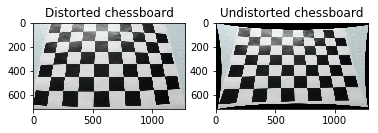

In [48]:
# Was a bit tricky to work with cv2.undistortPoints() since it doesn't output image coordinates
# when I called it like this: cv2.undistort(distorted, cameraMatrix, distCoeffs)
# Also doing this calculation once should be faster than letting cv2.undistort do it every time.
newCameraMatrix,roi = cv2.getOptimalNewCameraMatrix(cameraMatrix,distCoeffs,imageDim,1.,imageDim)
mapx,mapy = cv2.initUndistortRectifyMap(cameraMatrix,distCoeffs,None,newCameraMatrix,imageDim,cv2.CV_32FC1)
def undistortRoadImg(img):
    return cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

print('map x and y shapes: {} {}'.format(mapx.shape, mapy.shape))
def undistortRoadImgPoints(pts):
    #res = [(mapx[pt[1],pt[0]], mapy[pt[1],pt[0]]) for pt in np.rint(pts).astype(int)]
    #return np.array(res, np.float32)
    pts = pts[:,np.newaxis,:]
    res = cv2.undistortPoints(pts, cameraMatrix, distCoeffs, P=newCameraMatrix)
    res = np.squeeze(res)
    return res

# Show one img restored
distorted = calibimgs[3-1]
undistorted = undistortRoadImg(distorted) #cv2.undistort(distorted, cameraMatrix, distCoeffs)

plt.subplot(121)
plt.title('Distorted chessboard')
plt.imshow(distorted)

plt.subplot(122)
plt.title('Undistorted chessboard')
plt.imshow(undistorted)

[[   0.  800.]
 [   0.    0.]
 [ 300.    0.]
 [ 300.  800.]]
shape distorted: (720, 1280, 3)
[362.78082275390625, 623.3861694335938]
[635.5371704101562, 428.67431640625]
[678.66845703125, 428.6499328613281]
[982.8154296875, 622.649169921875]
[[ -2.44083881e-01  -4.62465311e-01   3.51618367e+02]
 [ -1.17275787e-03  -2.07445456e+00   8.90010721e+02]
 [ -1.25153196e-06  -2.41270548e-03   1.00000000e+00]]


True

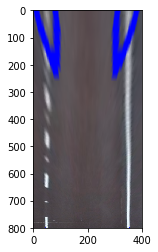

In [82]:
# Distorted coordinates for straight_lines2.jpg
srcpts = np.array([(308,656), (615,435), (666,435), (1012,656)], np.float32)
#srcpts = srcpts[:,np.newaxis,:]
srcptsUndistorted = undistortRoadImgPoints(srcpts) #cv2.undistortPoints(srcpts, cameraMatrix, distCoeffs)
#srcptsUndistorted = np.squeeze(srcptsUndistorted)
#print(srcptsUndistorted)

unwrappedDim = (300,800)
dstpts = np.multiply(np.array([(0,1), (0,0), (1,0), (1,1)], np.float32), np.float32(unwrappedDim))
print(dstpts)
M = cv2.getPerspectiveTransform(srcptsUndistorted, dstpts)

distorted = cv2.imread('test_images/straight_lines2.jpg')
print('shape distorted: {}'.format(distorted.shape))

undistorted = undistortRoadImg(distorted) #cv2.undistort(distorted, cameraMatrix, distCoeffs)

for pt in srcptsUndistorted.tolist():
    print(pt)
    cv2.circle(undistorted, (int(pt[0]), int(pt[1])), 5, (0,0,255), 2)

# The spacing in pixels to the side of the lane
sidemargin = 50
# Translate image 50 to right
T = np.identity(3)
T[0, 2] = sidemargin

M = np.matmul(T, M)
print(M)
wrapped = cv2.warpPerspective(undistorted, M, (unwrappedDim[0]+sidemargin*2,unwrappedDim[1]), flags=cv2.INTER_LINEAR)
plt.imshow(wrapped)
cv2.imwrite('unwrappedlines.jpg', wrapped)